In [9]:
from ultralytics import YOLO
from ultralytics.utils.ops import non_max_suppression, xyxy2xywh
import torch
import os
import cv2
import matplotlib.pyplot  as plt
import numpy as np
import pandas as pd
import onnxruntime as ort
import onnx
#!mkdir predictions
#!pip install onnxruntime

In [3]:
model = YOLO('yolov8m_trained.pt')
results = model('datasets/testing_images/vid_5_440.jpg')
#for r in results:
    #print(r.boxes)


image 1/1 /Users/bastianchuttarsing/Documents/CarObject_detection/datasets/testing_images/vid_5_440.jpg: 384x640 1 car, 175.7ms
Speed: 2.6ms preprocess, 175.7ms inference, 6.5ms postprocess per image at shape (1, 3, 384, 640)


In [4]:
prediction_dir = 'predictions'
test_img_list=[]
for result in results:
    if len(result.boxes.xyxy):
        name=result.path.split("/")[-1].split(".")[0]
        boxes=result.boxes.xyxy.cpu().numpy()
        scores=result.boxes.conf.cpu().numpy()
        
        test_img_list.append(name)
        
        label_file_path=os.path.join(prediction_dir,name+".txt")
        with open(label_file_path,"w+") as f:
            for score,box in zip(scores,boxes):
                text=f"{score:0.4f} "+" ".join(box.astype(str))
                f.write(text)
                f.write("\n")

In [5]:
def show_bbox(img,boxes,scores,axis,color=(0,255,0)):
    boxes=boxes.astype(int)
    scores=scores
    img=img.copy()
    for i,box in enumerate(boxes):
        score=f"{scores[i]:.4f}"
        cv2.rectangle(img,(box[0],box[1]),(box[2],box[3]),color,2)
        y=box[1]-10 if box[1]-10>10 else box[1]+10
        cv2.putText(img,score,(box[0],y),cv2.FONT_HERSHEY_SIMPLEX,0.5,color,2)
    
    axis.imshow(img)
    axis.axis("off")

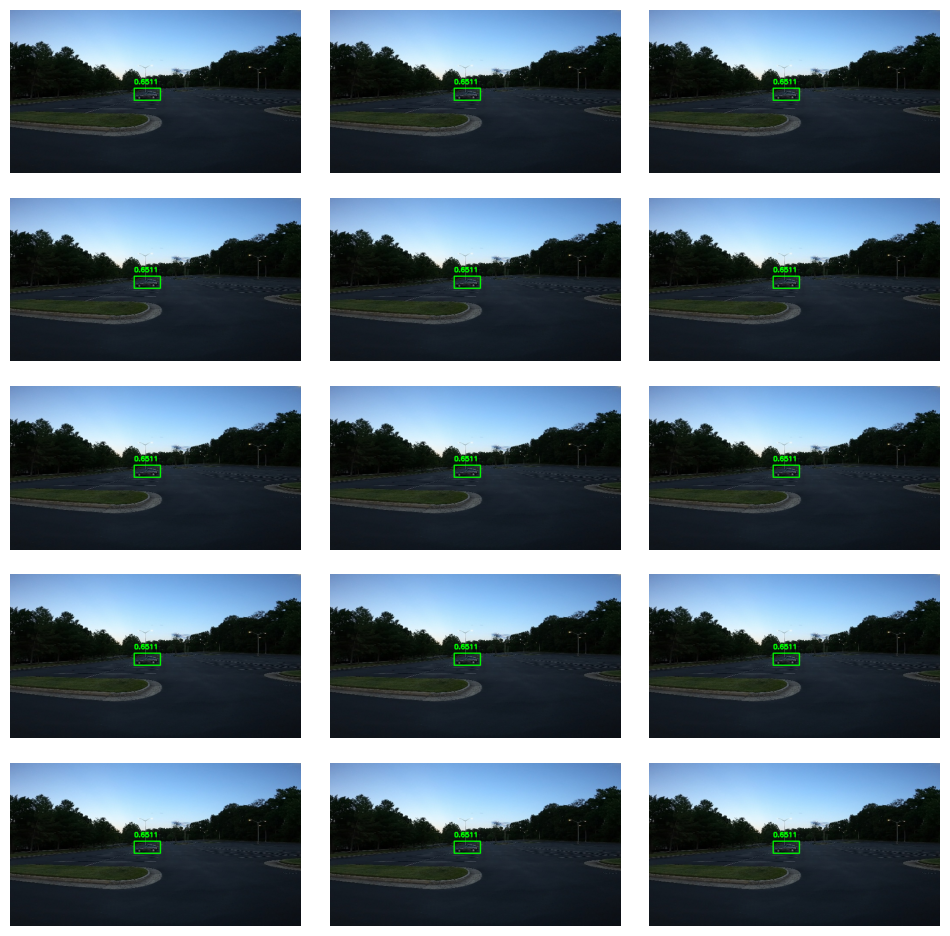

In [7]:
test_imgs_dir = 'datasets/testing_images'
fig,axes=plt.subplots(5,3,figsize=(12,12))
plt.subplots_adjust(wspace=0.1,hspace=0.1)
ax=axes.flatten()

imgs_name=np.random.choice(test_img_list,15)

for i,img_name in enumerate(imgs_name):
    img_file_path=os.path.join(test_imgs_dir,img_name+".jpg")
    img=cv2.imread(img_file_path)
    img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    
    label_file_path=os.path.join(prediction_dir,img_name+".txt")
    label=pd.read_csv(label_file_path,sep=" ",header=None).values
    scores=label[:,0]
    boxes=label[:,1:]
    show_bbox(img,boxes,scores,axis=ax[i])
    


In [7]:
#model.export(format='onnx')

In [8]:
# Load the ONNX model
model = onnx.load("yolov8m_trained.onnx")

In [9]:
onnx_model = ort.InferenceSession("yolov8m_trained.onnx")
input_data = np.array(cv2.imread('datasets/testing_images/vid_5_31520.jpg')).astype(np.float32)
input_data.shape


(380, 676, 3)

In [10]:
onnx_model.get_inputs()[0].name 

'images'

In [209]:
# Load an image
image = cv2.imread('datasets/testing_images/vid_5_440.jpg')
print(image.shape)
resized = cv2.resize(image, (640,640), interpolation = cv2.INTER_AREA).astype(np.float32)/ 255.
cv2.imwrite('vid_5_440_resized.jpg', resized)
resized = resized.transpose((2, 0, 1)) # convert to ONNX model format
#save image to disk
print(resized.shape)
input_data = np.expand_dims(resized, axis=0)  # Add batch dimension

(380, 676, 3)
(3, 640, 640)


In [210]:
ort_inputs = {onnx_model.get_inputs()[0].name: input_data}
ort_outputs = onnx_model.run(None, ort_inputs)

output= torch.from_numpy(np.asarray(ort_outputs))
output.shape

torch.Size([1, 1, 5, 8400])

In [214]:
def model(image):

    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    original_size = image.shape[:2][::-1]
    image = cv2.resize(image, (640,640), interpolation=cv2.INTER_LINEAR)
    image = np.expand_dims(image, axis=0).astype('float32') / 255.
    image = np.transpose(image, [0, 3, 1, 2])

    outputs = onnx_model.run(None, {'images': image})
    outputs = torch.from_numpy(np.asarray(outputs))
    outputs = non_max_suppression(outputs[0], conf_thres=0.2, max_det=100, agnostic=True)[0]
    print(outputs.shape)
    outputs[:, 0] = outputs[:, 0] * original_size[0] / 640
    outputs[:, 1] = outputs[:, 1] * original_size[1] / 640
    outputs[:, 2] = outputs[:, 2] * original_size[0] / 640
    outputs[:, 3] = outputs[:, 3] * original_size[1] / 640


    return outputs

image = cv2.imread('datasets/testing_images/vid_5_440.jpg')
outputs = model(image)

# draw rectangles and labels on the original image
for box in outputs:
    box = box.cpu().numpy()
    x1, y1, x2, y2, conf, cls_pred = box
    x1 = int(x1)
    x2 = int(x2)
    y1 = int(y1)
    y2 = int(y2)
    cv2.rectangle(image, (x1, y1), (x2, y2), (0,255,0), 2)
    cv2.putText(image, str((conf)), (x1, y1), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255,0), 2)

# display the image with bounding boxes and class labels in the output directory
cv2.imwrite('vid_5_31600.jpg', image)

torch.Size([1, 6])


True